First we import the necessary code

In [1]:
import torch
import torch.nn as nn
from src.transformer import DecoderTransformer
from src.data import random_values, create_signals, sine, add_noise
from src.train_eval import make_prediction
from src.train_eval import predict_next_values
from src.graph import plot_prediction
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MAX_SEQUENCE_LENGTH = 512

best_model = DecoderTransformer(
    output_parameter_count=1,
    d_model=128,
    num_heads=16,
    num_layers=2,
    d_ff=512,
    max_seq_length=MAX_SEQUENCE_LENGTH,
    dropout=0.1
).to(device)

best_model.load_state_dict(torch.load("models/signal_prediction_triple_noise.pt", map_location=device))

<All keys matched successfully>

In [ ]:
EVAL_COUNT = 256
TIME_STEP = 0.5 / MAX_SEQUENCE_LENGTH
MIN_OMEGA = 80
MAX_OMEGA = 120
NOISE = 0.01

frequencies_1 = random_values(EVAL_COUNT, MIN_OMEGA, MAX_OMEGA)
frequencies_2 = random_values(EVAL_COUNT, MIN_OMEGA, MAX_OMEGA)
frequencies_3 = random_values(EVAL_COUNT, MIN_OMEGA, MAX_OMEGA)
phases_1 = random_values(EVAL_COUNT, 0, 2 * torch.pi)
phases_2 = random_values(EVAL_COUNT, 0, 2 * torch.pi)
phases_3 = random_values(EVAL_COUNT, 0, 2 * torch.pi)
            
sine_1 = create_signals(
    omegas=frequencies_1,
    signal_function=sine,
    length=MAX_SEQUENCE_LENGTH * 2,
    time_step=TIME_STEP,
    phases=phases_1
)
        
sine_2 = create_signals(
    omegas=frequencies_2,
    signal_function=sine,
    length=MAX_SEQUENCE_LENGTH * 2,
    time_step=TIME_STEP,
    phases=phases_2
)

sine_3 = create_signals(
    omegas=frequencies_3,
    signal_function=sine,
    length=MAX_SEQUENCE_LENGTH * 2,
    time_step=TIME_STEP,
    phases=phases_3
)
    
signals = (sine_1 + sine_2 + sine_3) / 3
values, next_values = signals.split((MAX_SEQUENCE_LENGTH, MAX_SEQUENCE_LENGTH), dim=1)
values = add_noise(values, NOISE)
next_value = next_values[:, 0]

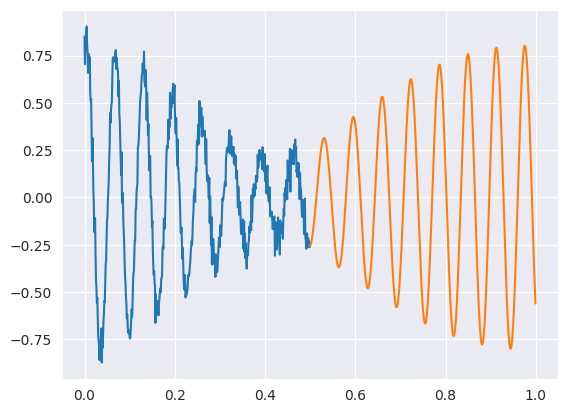

In [12]:
import numpy as np
index = 111
plt.plot(np.arange(MAX_SEQUENCE_LENGTH) * TIME_STEP, values[index])
plt.plot(np.arange(MAX_SEQUENCE_LENGTH) * TIME_STEP + MAX_SEQUENCE_LENGTH * TIME_STEP, next_values[index])
plt.show()

Evaluation MAE: 0.020276


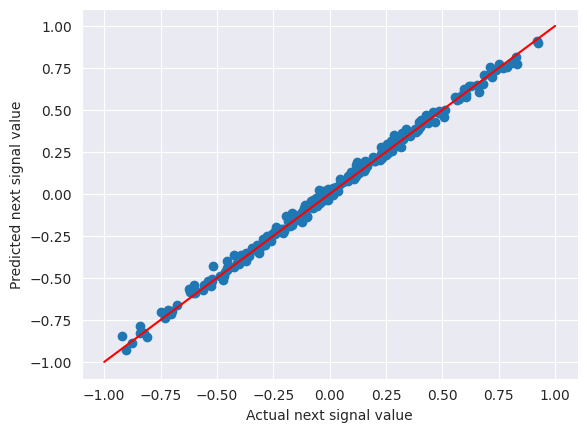

In [13]:
prediction = make_prediction(best_model, values, batch_size=16)
plt.scatter(next_value, prediction)
plt.plot([-1, 1], [-1, 1], "r")
plt.xlabel("Actual next signal value")
plt.ylabel("Predicted next signal value")
loss = nn.L1Loss()(next_value.flatten(), prediction).item()
print(f"Evaluation MAE: {loss:.6f}")

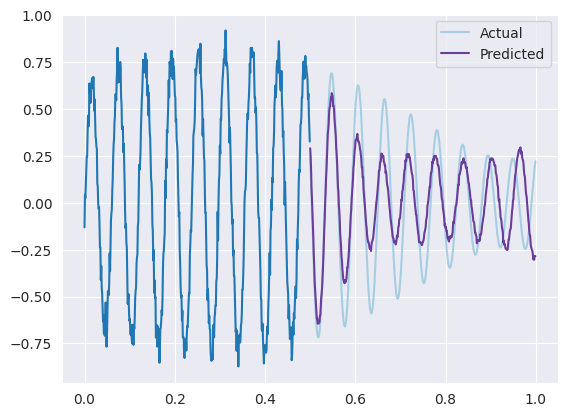

In [15]:
index = 42
_, predicted_values = predict_next_values(best_model, values[index], MAX_SEQUENCE_LENGTH, count=MAX_SEQUENCE_LENGTH)
fig = plot_prediction(values[index], next_values[index], predicted_values, TIME_STEP)